In this Kernel, I'd like to show you a very basic segmentation technique whihc only applies pure computer vision techniques. Nothing fancy.

At first, I'll show the step-by-step processing and after that I will create the submission for the competition.

With this kernel, I could reach *0.229 LB* which is not very nice but I am sure that with a few tweaks we could get better score. And consider that **we don't even use the train data**! which is pretty awesome in my opinion.

In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'

In [3]:
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

In [4]:
test_image_paths = [glob.glob(join(TEST_PATH, test_id, "images", "*"))[0] for test_id in test_ids]

# Step-by-step processing

In [5]:
tmp_image_path = np.random.choice(test_image_paths)
tmp_image = cv2.imread(tmp_image_path, cv2.IMREAD_GRAYSCALE)

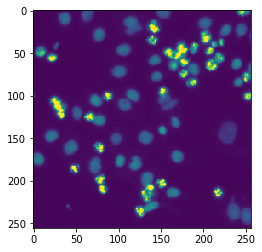

In [6]:
plt.imshow(tmp_image)

Now comes the crucial part of the processing. First we would like to create a binary matrix from the original image. The ones in the matrix are considered to be objects and the zeros are the background. So If we don't do this correctly we're going to loose a lot of inforamtion.

In [7]:
ret, thresh = cv2.threshold(tmp_image, 100, 255, cv2.THRESH_OTSU)

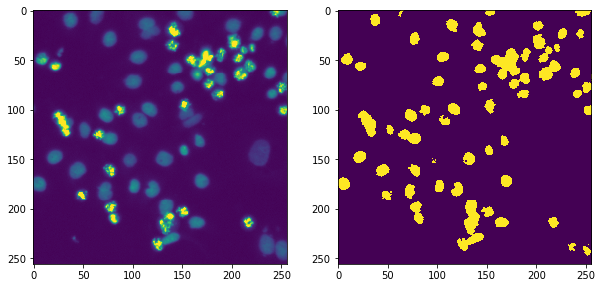

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(tmp_image)
axs[1].imshow(thresh)

There are images where the thresholding does not help because the ones will be the background and the zeros the objects. This happend when the background is more brighter than the objects.

But how we detect this?

We just have to find the contours of the objects. Than calculate the area of the contour and if it is above some threshold value than we will just invert the image.

In [9]:
_, cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

In [10]:
max_cnt_area = cv2.contourArea(cnts[0])

In [11]:
print("The area of the largest object is: {0}".format(max_cnt_area))

The area of the largest object is: 541.5


This is the part where we invert the threshold image if we are not satisfied with the area of the largest contour

In [12]:
if max_cnt_area > 50000:
    ret, thresh = cv2.threshold(tmp_image, 100, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

And here comes the *morphology*.

We will use:
- Dilation (read more: https://homepages.inf.ed.ac.uk/rbf/HIPR2/dilate.htm)
- Erosion (read more: https://homepages.inf.ed.ac.uk/rbf/HIPR2/erode.htm)

In [13]:
mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))

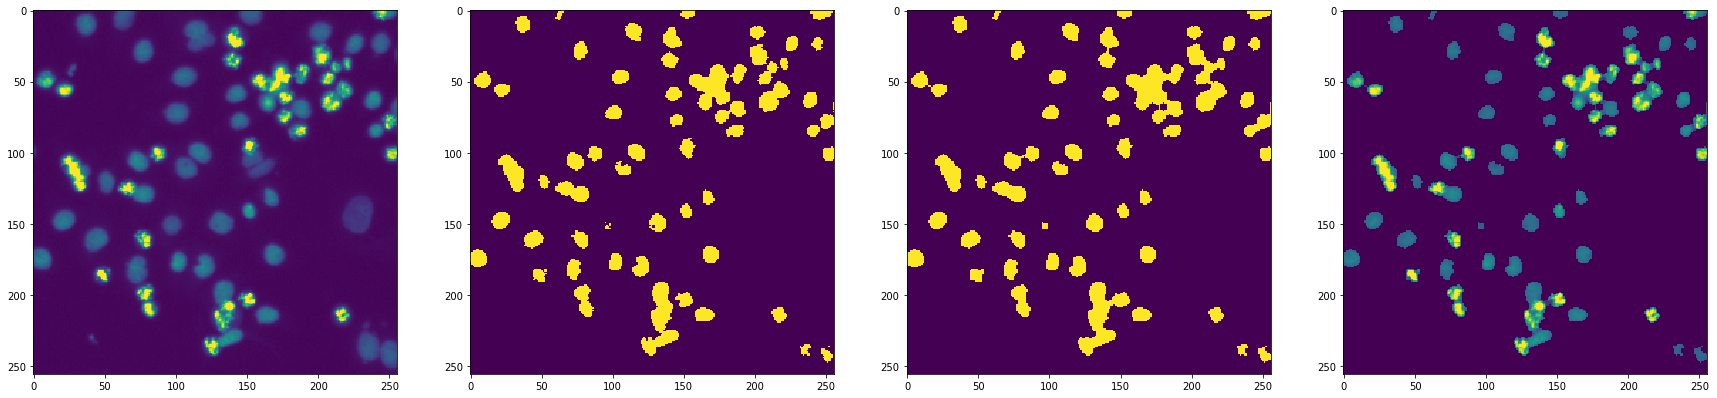

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(30,30))
axs[0].imshow(tmp_image)
axs[1].imshow(thresh)
axs[2].imshow(mask)
axs[3].imshow(cv2.bitwise_and(tmp_image, tmp_image, mask=mask))

# Process the test images for submission

I separated the logic into 2 funcrtions so it is easier to use it.

In [15]:
def threshold(image_gray):
    image_gray = cv2.GaussianBlur(image_gray, (7, 7), 1)
    ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU)
    
    _, cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    max_cnt_area = cv2.contourArea(cnts[0])
    
    if max_cnt_area > 50000:
        ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    return thresh

def apply_morphology(thresh):
    mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    return mask

Now we only have to create the mask images from the test images

In [16]:
segmented = []
for test_image_path in test_image_paths:
    tmp_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    
    thresh = threshold(tmp_image)
    mask = apply_morphology(thresh)
    
    segmented.append(mask)

In [17]:
# Run length Encoding from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python

from skimage.morphology import label

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [18]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(segmented[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [19]:
submission_df = pd.DataFrame()
submission_df['ImageId'] = new_test_ids
submission_df['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

In [20]:
submission_df.sample(3)

,ImageId,EncodedPixels
612,1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6...,153681 4 154205 5 154729 5 155253 6 155779 2
375,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,18300 5 18554 10 18809 13 19065 14 19321 15 19...
524,ca20076870e8fb604e61802605a9ac45419c82dd3e2340...,15875 1 16394 2 16913 3 17432 4 17951 5 18470 ...


In [21]:
if not len(np.unique(submission_df["ImageId"])) == len(test_ids):
    print("Submission is not complete")
    print("Missing test ids: {0}".format(set(test_ids).difference(set(np.unique(submission_df["ImageId"])))))
else:
    print("Submission is complete")

Submission is complete


In [22]:
submission_df.to_csv('submission_pure_cv.csv', index=False)